In [1]:
import sys

sys.path.append("..")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from mango.mango import Mango
from mango.utils import plot_loss_reward
from mango.environments import frozen_lake
from mango.actions.abstract_actions import Grid2dActions, Grid2dMovementOnehot

obs.shape=(3, 16, 16), obs.dtype=dtype('uint8')


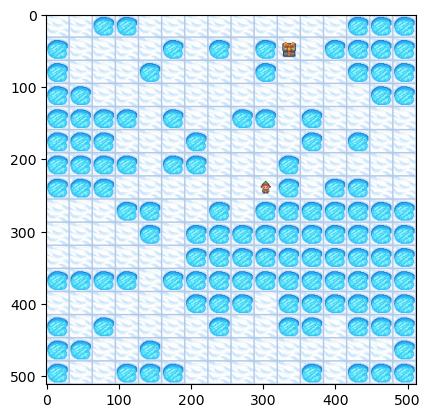

In [ ]:
init_kwargs = dict(map_name="RANDOM", shape=(16, 16), p=0.5, goal_pos=None, start_pos=None)
env = frozen_lake.CustomFrozenLakeEnv(**init_kwargs)  # type: ignore
env = frozen_lake.ReInitOnReset(env, **init_kwargs)
env = frozen_lake.TensorObservation(env, one_hot=True)

env_shape = (env.unwrapped.ncol, env.unwrapped.nrow)  # type: ignore
obs, _ = env.reset()
print(f"{obs.shape=}, {obs.dtype=}")
plt.imshow(env.render())  # type: ignore
plt.show()

In [ ]:
n_layers = 3
gamma = 0.8
mango = Mango(
    environment=env,
    abstract_actions=[
        Grid2dMovementOnehot(
            cell_shape=(2**i, 2**i),
            grid_shape=env_shape,
            agent_channel=0,
            add_valid_channel=True,
            reward=(1 - gamma),
            p_termination=0.1,
        )
        for i in range(1, n_layers)
    ],
    policy_params=dict(
        lr=1e-4,
        gamma=gamma,
        net_params=dict(
            hidden_channels=[4, 4, 4],
            hidden_features=[64, 16],
            activation_out=torch.nn.Tanh(),
            batch_norm=False,
            device=torch.device("cuda") if torch.cuda.is_available() else None,
        ),
    ),
)
print(mango)

Mango(
  (1): MangoEnv(
    (environment): <TensorObservation<ReInitOnReset<CustomFrozenLakeEnv instance>>>
  )
  (2): MangoLayer(
    (abs_actions): Grid2dMovementOnehot(cell_shape=(2, 2), grid_shape=(16, 16), p_termination=0.1, reward=0.19999999999999996, agent_channel=0, add_valid_channel=True)
    (policy): DQnetPolicyMapper(comand_space=Discrete(4), action_space=Discrete(4))
  )
  (3): MangoLayer(
    (abs_actions): Grid2dMovementOnehot(cell_shape=(4, 4), grid_shape=(16, 16), p_termination=0.1, reward=0.19999999999999996, agent_channel=0, add_valid_channel=True)
    (policy): DQnetPolicyMapper(comand_space=Discrete(4), action_space=Discrete(4))
  )
)


In [ ]:
N = 10000
for layer in [1, 2]:
    for randomness in (pbar := tqdm(np.linspace(0.99, 0.0, N))):
        pbar.set_description(f"randomness: {randomness:.3f}")
        mango.set_randomness(randomness, layer=layer)
        obs, reward, term, trunc, info = mango.explore(layer=layer, episode_length=5)
        mango.train(layer=layer)
mango.save_to("trained_models/frozen_lake_mango.pickle")

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

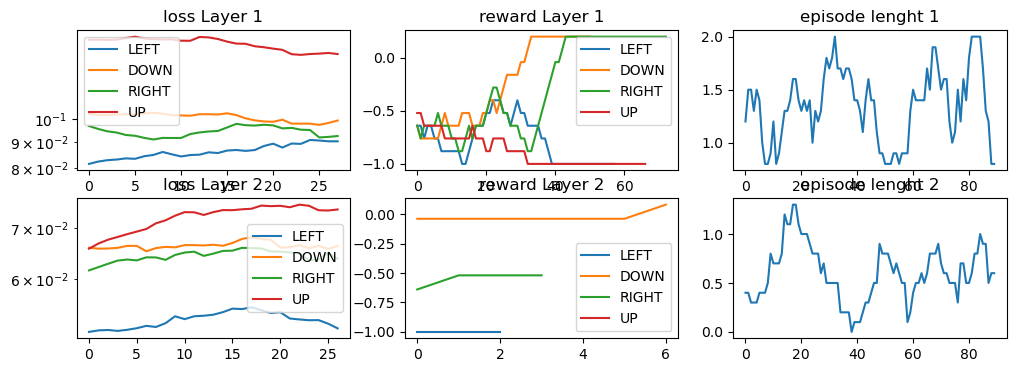

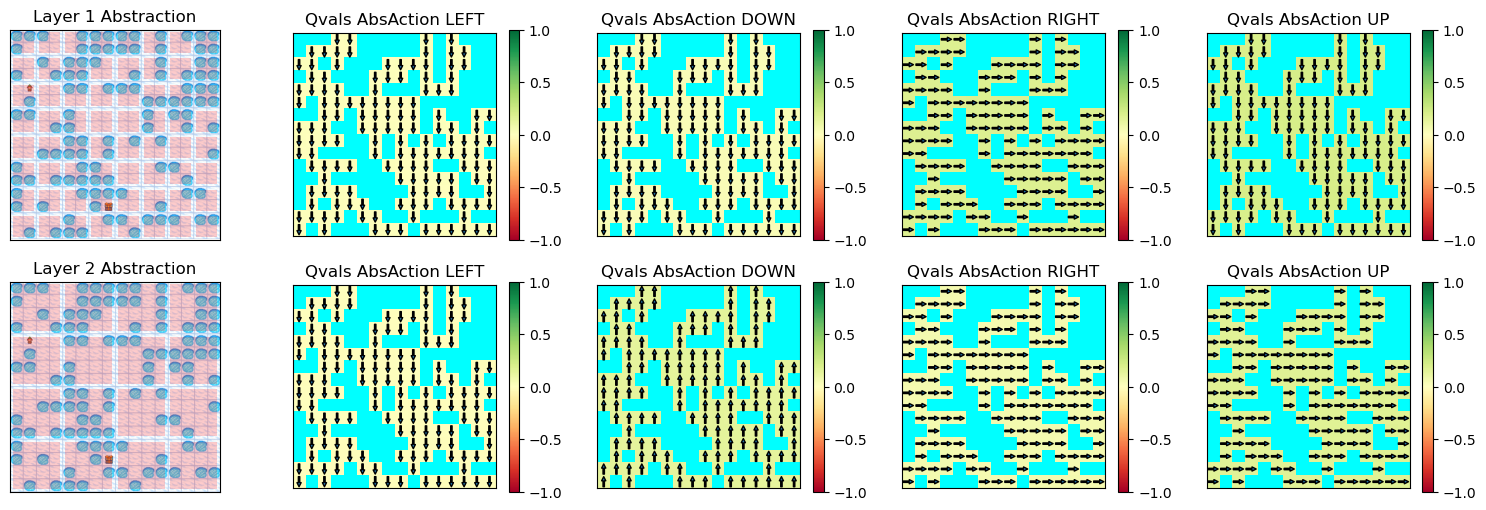

In [ ]:
plot_loss_reward(mango, Grid2dActions)
frozen_lake.plot_all_qvals(mango)
plt.show()

In [ ]:
obs, info = mango.reset()
frozen_lake.plot_all_qvals(mango)
plt.show()

trajectory = [obs]
for action in Grid2dActions:
    print(action.name)
    for step in range(10):
        obs, reward, trunc, term, info = mango.step((-1, action.value))
        trajectory.extend(info["mango:trajectory"])
        if not info["mango:truncated"]:
            break
    frozen_lake.plot_all_abstractions(mango, trajectory)
    plt.show()